# Movies Data Project

## Miri Hazanov, Alon Maharshak

### First step-collect and preapre the data



#### During this project we will work with the "Cornell Movie-Dialogs Corpus" created by the Cornell University

Our first step is to understand the data.

* Import the relevent Packeges 
* Open the movie titles files and the movie lines file.

In [25]:
import pandas as pd
import nltk
import re
import string 

fileName='C:/Users/Alon/Desktop/Alon/School/4th year/SemesterB/Data science/Project/Data/cornell movie-dialogs corpus/movie_lines.txt'
with open(fileName) as f:
    lines = f.readlines()
fileName='C:/Users/Alon/Desktop/Alon/School/4th year/SemesterB/Data science/Project/Data/cornell movie-dialogs corpus/movie_titles_metadata.txt'
with open(fileName) as f:
    titles = f.readlines()

Now lets print an exapmle so we can see how our meta data and raw data looks like

In [15]:
print(titles[0])
print(lines[0])

m0 +++$+++ 10 things i hate about you +++$+++ 1999 +++$+++ 6.90 +++$+++ 62847 +++$+++ ['comedy', 'romance']

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!



As we can see, the data has a '+++$+++' seperator, so now we can start work on the data.

Our stages we'll be:
* Create a list of each genre using the generes list in the titles file
* Get the title with the most lines in each genre so well have a lot of lines to work with
* Clean the data, getting only the movie line after cleaning of lower case and other unnecessary marks.
* Create a csv file with the Line, movie name and movie genre.

The reason we are using the Genere factor is because we want the movies to have big diffrences in style, so we can better train the model later.

### Create list function:
returns a list of all the movie id's that are relevent to a selected genre.

In [26]:
def createList(genre):
    ans=[]
    for title in titles:
        att=title.split('+++$+++')
        if genre in att[5]:
            ans.append(att[0])
    return ans

### Get the movie with the most lines function

In [27]:
def getMaxLines(movielist):
    x=0
    maxMovie=''
    for movie in movielist:
        movieline='+++$+++ '+movie+'+++$+++'
        movieLines=[line for line in lines if movieline in line]
        if len(movieLines)>x:
            x=len(movieLines)
            maxMovie=movie
    return maxMovie

### Clean the movie data function

* takes the raw line, strips only the movie line.
* remove from the movie line unnecessary marks and swtich to lower case 
* strip the movie name 
* Check the parameter K, that tells you how many sentences you want to put together

Returns a tuple of the movie name + a list of all the movie lines(clean)

In [28]:
def cleanMovie(movie,k):
    num=int(movie[1:])
    movieLinesRaw=[line for line in lines if '+++$+++ '+ movie+'+++$+++' in line]
    MovieLinesClean=[]
    results=[]
    for line in movieLinesRaw:
         att=line.split('+++$+++')
         MovieLinesClean.append(att[4])
    returnLines=[]
    att=titles[num].split('+++$+++')
    results.append(att[1])
    for line in MovieLinesClean:
        line=line.lower()
        for char in string.punctuation:
            if char!="'":
                line = line.replace(char, ' ')
        line=' '.join(line.split())
        returnLines.append(line)
    
    new_results=[]
    if k>1:
        for i in range(len(returnLines)-1):
            line=''
            if i%k==0:
                line=returnLines[i]+' '+returnLines[i+1]
                new_results.append(line)
        results.append(new_results)
    else:
        results.append(returnLines)
    return results

### Create CSV files function:

In [29]:
def makeCsv(movie,name,genre):
    df=pd.DataFrame()
    df['lines']=movie
    df['name']=name
    return df

### Now we can activate all of the stages for all the 3 movies and concatene them into one csv file:

In [38]:
def makeDB(k):
    adventureList=createList('adventure') 
    dramaList=createList('drama') 
    comedyList=createList('comedy') 

    maxAdventure=getMaxLines(adventureList)
    maxDrama=getMaxLines(dramaList)
    maxComedy=getMaxLines(comedyList)

    movieDrama=cleanMovie(maxDrama,k)
    movieComedy=cleanMovie(maxComedy,k)
    movieAdventure=cleanMovie(maxAdventure,k)

    dramaDf=makeCsv(movieDrama[1],movieDrama[0],'Drama')
    comedyDf=makeCsv(movieComedy[1],movieComedy[0],'Comedy')
    AdventureDf=makeCsv(movieAdventure[1],movieAdventure[0],'Adventure')
    result = pd.concat([dramaDf,comedyDf,AdventureDf])
    result.to_csv('C:/Users/Alon/Desktop/Alon/School/4th year/SemesterB/Data science/Project/Data/MoviesLines'+str(k)+'.csv')
    return result

## Second part of the project:
### building calssification Model

In this part we will take the list of movie lines that we collected earlier and try to build a classification model out of it.

First we'll need to transform the vocabulary of words into features- we'll use the Bag of words technique.
We'll use the CountVectorizer package and use a "word" analyzer to get maximun features for our model.
We'll try to play with the K parameters and see when do we get the best results.

## createModels

In this function we get the movie lines as a parameter and create diffrent models, returning the result.
* We divide the set into train and test
* we create each model, fit and score.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn import neighbors 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
def createModels(result):
    np.random.seed(123)
    x = np.random.rand(len(result['lines'])) < 0.8
    train_x = train_data_features[x]
    test_x = train_data_features[~x]
    train_y = result.loc[x,"name"]
    test_y = result.loc[~x,"name"]

    forest = RandomForestClassifier(n_estimators = 100) 
    model = forest.fit( train_x, train_y )
    forestScore=model.score(test_x,test_y)
    print("RandomForestClassifier: {}".format(forestScore))

    knn = neighbors.KNeighborsClassifier(3) 
    model=knn.fit(train_x, train_y) 
    knnScore = model.score(test_x,test_y) 
    print("knn: {}".format(knnScore))

    svml = svm.LinearSVC() 
    model=svml.fit(train_x, train_y) 
    svmScore=model.score(test_x,test_y)
    print("svm: {}".format(svmScore))

    tree = DecisionTreeClassifier()
    model = tree.fit( train_x, train_y )
    treeScore=model.score(test_x,test_y)
    print("DecisionTreeClassifier: {}".format(treeScore))

    Reg = LogisticRegression()
    model = Reg.fit( train_x, train_y )
    RegScore=model.score(test_x,test_y)
    print("LogisticRegression: {}".format(RegScore))
    data=[knnScore,forestScore,svmScore,treeScore,RegScore]
    return data

### Visualization:

Thiss function gets all of the models scores and create a bar graph so we can see which model is best

In [33]:
def createPlot(data):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.set_ylabel('Scores')
    plt.xlabel('Model')
    ax.set_title('Scores by model')
    index = np.arange(5)
    plt.bar(index,data,alpha=0.4, color='r',label='Model')
    ax.set_xticklabels(('G1', 'KNN', 'RandomForest', 'SVM', 'DecisionTree','LogisticReg'))
    plt.tight_layout()
    plt.show()

## Build the Model:
### Main program

After we created all the function that we need we'll do the following steps.
1. create a data set, each time using a difftrent K(how many sentences do we want to put together)
2. Create the BOW with 5000 features
3. Create the models and return the scores for each one.
4. Plot the scores and see which model is the best.

(3997, 2886)
RandomForestClassifier: 0.6326276463262764
knn: 0.48816936488169366
svm: 0.6737235367372354
DecisionTreeClassifier: 0.5529265255292652
LogisticRegression: 0.6787048567870486


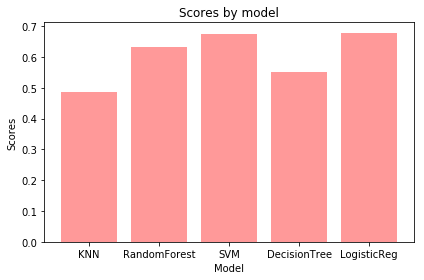

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
result=makeDB(1)
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,preprocessor = None,stop_words = None,max_features = 5000)
train_data_features = vectorizer.fit_transform(result['lines'])
train_data_features = train_data_features.toarray()
vocab = vectorizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)
print(train_data_features.shape)
data=createModels(result)
createPlot(data)

### We can see that when we address each sentence separately the highest score is 67.8% with the Logisitc Regression model.

Now let's see what happen when we increase our K.

### We'll run a loop from 2 to 5, and see which K gives us the best reuslts

(1998, 2886)
RandomForestClassifier: 0.6539379474940334
knn: 0.513126491646778
svm: 0.7303102625298329
DecisionTreeClassifier: 0.5465393794749404
LogisticRegression: 0.747016706443914


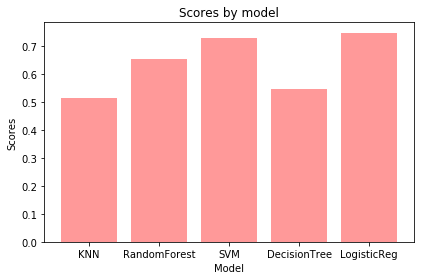

(1332, 2384)
RandomForestClassifier: 0.6616541353383458
knn: 0.48120300751879697
svm: 0.6766917293233082
DecisionTreeClassifier: 0.5902255639097744
LogisticRegression: 0.7218045112781954


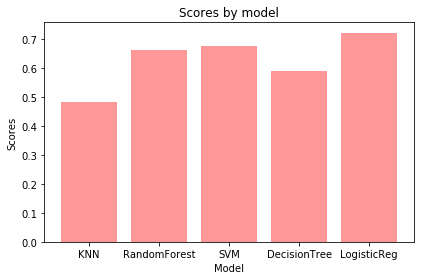

(1000, 1980)
RandomForestClassifier: 0.7171717171717171
knn: 0.5252525252525253
svm: 0.696969696969697
DecisionTreeClassifier: 0.5505050505050505
LogisticRegression: 0.7525252525252525


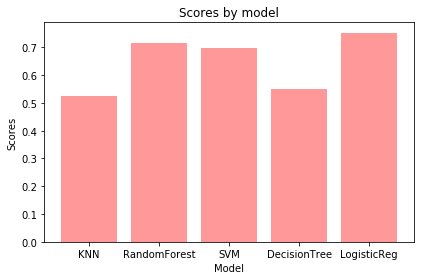

(800, 1780)
RandomForestClassifier: 0.6024096385542169
knn: 0.4759036144578313
svm: 0.6686746987951807
DecisionTreeClassifier: 0.5120481927710844
LogisticRegression: 0.6746987951807228


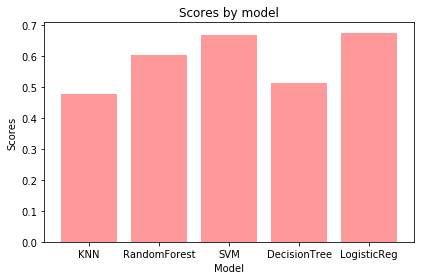

In [41]:
for i in range(2,6):
    result=makeDB(i)
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,preprocessor = None,stop_words = None,max_features = 5000)
    train_data_features = vectorizer.fit_transform(result['lines'])
    train_data_features = train_data_features.toarray()
    vocab = vectorizer.get_feature_names()
    dist = np.sum(train_data_features, axis=0)
    print(train_data_features.shape)
    data=createModels(result)
    createPlot(data)

## Results:

1. AS we can see The scores were better with higher K until we reached the value of 5. 
2. In all of our model, Logistic regression was the best fit.
3. the best score was 75.5% that was achived when K=4.